# K-Fold CV for Boosting Methods Using SKLearn 

In [1]:
#Importing required libraries
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
import wfdb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from numpy import mean
from numpy import absolute
from numpy import sqrt
import pandas as pd
import random

In [2]:
import xgboost as xgb
from sklearn import metrics
from lightgbm import LGBMClassifier

import lightgbm
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 70 #display 70 dpi in Jupyter Notebook, may consider100 dpi 
plt.rcParams['savefig.dpi'] = 300 #define 300 dpi for saving figures

import seaborn as sns
## here are some settings 
sns.set_style('whitegrid')
sns.set(rc={"figure.dpi":70, 'savefig.dpi':300}) #defining dpi setting
sns.set_context('notebook')
sns.set_style("ticks")
from IPython.display import set_matplotlib_formats

### To load sklearn dataset
sklearn.datasets.load_breast_cancer(*, return_X_y=False, as_frame=False)[source]¶

Load and return the breast cancer wisconsin dataset (classification).

In [4]:
#data = load_breast_cancer(as_frame = True); 
#df = data.frame; 
#print(df.shape)
# In this block use the code we looked at on 6/30 as a reference to save our rr-intervals as a .
rlist = []
records = 'mit-bih-raw\RECORDS' # Replace the _______ with the name of the records file in your MIT-BIH data folder
with open(records) as rfile: #Then we open the file 
                             #The 'with' command only opens the file while we are in it. Automatically closes the file when we're not
    for record in rfile:  # Then we iterate through the lines in the file
        record = record[0:len(record)-1] # Remove any erronious new line characters at the end ('\n')
        rlist.append(record) # Then build an array with it
        

###### Step 1: Initialize all Arrays
             # Below, replace all of the ___ with the command that declares an array/list
             # hint: https://stackoverflow.com/questions/1514553/how-to-declare-an-array-in-python
samples = [] # will house the samples of all subjects
good_list = [] # will list the names of the subjects we successfully extracted
bad_list = [] # will house the names of the subjects we failed to extract
qrs = [] # will house the indices of R-Peaks for all subjects
atr_label = [] # will house the labels for each rhythm annotation for all subjects
atr_locs = [] # will house the locations corresponding to the rhythm annotation labels


###### Step 2: Extract Information
for x in tqdm(rlist): #this will iterate through te records that we found above
  
    try: # A try statement will run the except statement if for some reason the try commands fail
         # In this case I use the try statement because one of the subjects has no signal data causing failure
         # I then use bad_list and good_list so that all of the indices in rlist match with the arrays we initialized in Step 1, above
        ######################################################
            # Below find the wfdb function that will return the information that is described below 
        # Then replace _____ with the correct function call
        samp = wfdb.rdsamp('mit-bih-raw/'+x) # wfdb._____(file_location) will read the signal & header data and return a 2 value array
            # samp[0] - the signal data is the raw reading from the ecg. Each value is a sample taken.
            # samp[1] - the header data includes things about the signal data such as:
              # samples per section, denoted 'fs'
              # number of signals, denoted 'n_sig'
            
        ######################################################
        samples.append(samp) #add it to our array for all subject
            #What is our file extension that has the annotation we want? Find it here and replace _____ with it 
            #hint: READ THE VARIABLE NAMES!!!!
        qrs_tmp = wfdb.rdann('mit-bih-raw/'+x, extension='qrs') #extract the QRS Info
        qrs_locs = np.array(qrs_tmp.sample, dtype='int') #Get just the loccation of R-Peaks from the QRS Info
        qrs.append(qrs_locs) # Add to our array for all subjects
        
            #Do the same thing here
        atr = wfdb.rdann('mit-bih-raw/'+x,extension='atr') #extract the atr info which stores the rhythm type(s) over the whole signal
        atr_label.append(atr.aux_note) # aux_note stores the type of rhythm - main two are '(N' for normal and '(AFIB' for AFIB
        atr_locs.append(np.append(atr.sample, len(samp[0]))) #I add the length of the whole sample to the end for better visualization later
        
        good_list.append(x) # when all extraction is successful append the record name to good_list
    except Exception as exep:
        print(exep) # Alert the user of an exception
        bad_list.append(x) # add to the bad list

        

  0%|                                                                                           | 0/25 [00:00<?, ?it/s]

sampto must be greater than sampfrom
sampto must be greater than sampfrom


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:15<00:00,  1.57it/s]


In [5]:
features_df_list = []
for subject in good_list:
    data = pd.read_csv(f'subject-features-dataframes/subject{subject}.csv')
    data = data.assign(Subject = subject)
    #print(data)
    features_df_list.append(data)
#features_maindf = pd.concat(features_df_list, ignore_index = True)

In [6]:
#df.head(5)
# df.info()
# df.describe()
#features_df_list[0]
counter = 0
testing_arr = []
training_arr = []
for subject in features_df_list:
    if counter != 22:
        training_arr.append(subject)
    else:
        testing_arr.append(subject)
    counter += 1
    
print(len(training_arr))

22


In [7]:
features_maindf = pd.concat(features_df_list, ignore_index = True)
print(features_maindf.columns)

Index(['Unnamed: 0', 'StoS', 'StoR', 'StoL', 'RtoS', 'RtoR', 'RtoL', 'LtoS',
       'LtoR', 'LtoL', 'STD', 'CoefVar', 'Range', 'Volatility', 'ShEn',
       'AppEn', 'SampEn', 'Rhythm', 'Subject'],
      dtype='object')


C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.618356	valid_0's binary_logloss: 0.571408
[2]	training's binary_logloss: 0.55755	valid_0's binary_logloss: 0.521635
[3]	training's binary_logloss: 0.505937	valid_0's binary_logloss: 0.479841
[4]	training's binary_logloss: 0.461077	valid_0's binary_logloss: 0.444658
[5]	training's binary_logloss: 0.422435	valid_0's binary_logloss: 0.413974
[6]	training's binary_logloss: 0.38893	valid_0's binary_logloss: 0.388499
[7]	training's binary_logloss: 0.359628	valid_0's binary_logloss: 0.365992
[8]	training's binary_logloss: 0.333592	valid_0's binary_logloss: 0.347248
[9]	training's binary_logloss: 0.310354	valid_0's binary_logloss: 0.331608
[10]	training's binary_logloss: 0.289934	valid_0's binary_logloss: 0.3166
[11]	training's binary_logloss: 0.271768	valid_0's binary_logloss: 0.30428
[12]	training's binary_logloss: 0.255338	valid_0's binary_logloss: 0.293393
[13]	training's binary_logloss: 0.240926	valid_0's binary_logloss: 0.283978
[14]	training's binary_log

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.618356	valid_0's binary_logloss: 0.571408
[2]	training's binary_logloss: 0.55755	valid_0's binary_logloss: 0.521635
[3]	training's binary_logloss: 0.505937	valid_0's binary_logloss: 0.479841
[4]	training's binary_logloss: 0.461077	valid_0's binary_logloss: 0.444658
[5]	training's binary_logloss: 0.422435	valid_0's binary_logloss: 0.413974
[6]	training's binary_logloss: 0.38893	valid_0's binary_logloss: 0.388499
[7]	training's binary_logloss: 0.359628	valid_0's binary_logloss: 0.365992
[8]	training's binary_logloss: 0.333592	valid_0's binary_logloss: 0.347248
[9]	training's binary_logloss: 0.310354	valid_0's binary_logloss: 0.331608
[10]	training's binary_logloss: 0.289934	valid_0's binary_logloss: 0.3166
[11]	training's binary_logloss: 0.271768	valid_0's binary_logloss: 0.30428
[12]	training's binary_logloss: 0.255338	valid_0's binary_logloss: 0.293393
[13]	training's binary_logloss: 0.240926	valid_0's binary_logloss: 0.283978
[14]	training's binary_log

[37]	training's binary_logloss: 0.108413	valid_0's binary_logloss: 0.238218
[38]	training's binary_logloss: 0.106683	valid_0's binary_logloss: 0.239617
[39]	training's binary_logloss: 0.10502	valid_0's binary_logloss: 0.240261
[40]	training's binary_logloss: 0.103539	valid_0's binary_logloss: 0.241746
[41]	training's binary_logloss: 0.10208	valid_0's binary_logloss: 0.241625
[42]	training's binary_logloss: 0.100805	valid_0's binary_logloss: 0.242851
[43]	training's binary_logloss: 0.0994949	valid_0's binary_logloss: 0.242336
[44]	training's binary_logloss: 0.0982209	valid_0's binary_logloss: 0.24397
[45]	training's binary_logloss: 0.0970058	valid_0's binary_logloss: 0.244737
[46]	training's binary_logloss: 0.0959482	valid_0's binary_logloss: 0.244193
[47]	training's binary_logloss: 0.0949394	valid_0's binary_logloss: 0.244539
[48]	training's binary_logloss: 0.0940318	valid_0's binary_logloss: 0.244729
[49]	training's binary_logloss: 0.0930519	valid_0's binary_logloss: 0.245185
[50]	tra

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	training's binary_logloss: 0.462222	valid_0's binary_logloss: 0.439001
[5]	training's binary_logloss: 0.423927	valid_0's binary_logloss: 0.403011
[6]	training's binary_logloss: 0.390808	valid_0's binary_logloss: 0.372501
[7]	training's binary_logloss: 0.361399	valid_0's binary_logloss: 0.345071
[8]	training's binary_logloss: 0.335503	valid_0's binary_logloss: 0.321059
[9]	training's binary_logloss: 0.312644	valid_0's binary_logloss: 0.299882
[10]	training's binary_logloss: 0.292276	valid_0's binary_logloss: 0.281127
[11]	training's binary_logloss: 0.274365	valid_0's binary_logloss: 0.264247
[12]	training's binary_logloss: 0.258079	valid_0's binary_logloss: 0.249298
[13]	training's binary_logloss: 0.243613	valid_0's binary_logloss: 0.23619
[14]	training's binary_logloss: 0.230575	valid_0's binary_logloss: 0.22492
[15]	training's binary_logloss: 0.218974	valid_0's binary_logloss: 0.214482
[16]	training's binary_logloss: 0.208254	valid_0's binary_logloss: 0.204929
[17]	training's bina

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.618031	valid_0's binary_logloss: 0.587241
[2]	training's binary_logloss: 0.557826	valid_0's binary_logloss: 0.529984
[3]	training's binary_logloss: 0.506602	valid_0's binary_logloss: 0.481112
[4]	training's binary_logloss: 0.462222	valid_0's binary_logloss: 0.439001
[5]	training's binary_logloss: 0.423927	valid_0's binary_logloss: 0.403011
[6]	training's binary_logloss: 0.390808	valid_0's binary_logloss: 0.372501
[7]	training's binary_logloss: 0.361399	valid_0's binary_logloss: 0.345071
[8]	training's binary_logloss: 0.335503	valid_0's binary_logloss: 0.321059
[9]	training's binary_logloss: 0.312644	valid_0's binary_logloss: 0.299882
[10]	training's binary_logloss: 0.292276	valid_0's binary_logloss: 0.281127
[11]	training's binary_logloss: 0.274365	valid_0's binary_logloss: 0.264247
[12]	training's binary_logloss: 0.258079	valid_0's binary_logloss: 0.249298
[13]	training's binary_logloss: 0.243613	valid_0's binary_logloss: 0.23619
[14]	training's binary

[18]	training's binary_logloss: 0.189728	valid_0's binary_logloss: 0.189414
[19]	training's binary_logloss: 0.181814	valid_0's binary_logloss: 0.182602
[20]	training's binary_logloss: 0.174375	valid_0's binary_logloss: 0.176883
[21]	training's binary_logloss: 0.167878	valid_0's binary_logloss: 0.170973
[22]	training's binary_logloss: 0.161679	valid_0's binary_logloss: 0.16639
[23]	training's binary_logloss: 0.156153	valid_0's binary_logloss: 0.162218
[24]	training's binary_logloss: 0.151039	valid_0's binary_logloss: 0.158346
[25]	training's binary_logloss: 0.146166	valid_0's binary_logloss: 0.154518
[26]	training's binary_logloss: 0.141891	valid_0's binary_logloss: 0.151304
[27]	training's binary_logloss: 0.138127	valid_0's binary_logloss: 0.148921
[28]	training's binary_logloss: 0.134366	valid_0's binary_logloss: 0.146159
[29]	training's binary_logloss: 0.131091	valid_0's binary_logloss: 0.144326
[30]	training's binary_logloss: 0.12805	valid_0's binary_logloss: 0.142
[31]	training's b

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.618971	valid_0's binary_logloss: 0.555954
[2]	training's binary_logloss: 0.558959	valid_0's binary_logloss: 0.494263
[3]	training's binary_logloss: 0.507991	valid_0's binary_logloss: 0.440917
[4]	training's binary_logloss: 0.464155	valid_0's binary_logloss: 0.395268
[5]	training's binary_logloss: 0.425893	valid_0's binary_logloss: 0.355017
[6]	training's binary_logloss: 0.392805	valid_0's binary_logloss: 0.319867
[7]	training's binary_logloss: 0.36368	valid_0's binary_logloss: 0.28888
[8]	training's binary_logloss: 0.338182	valid_0's binary_logloss: 0.261857
[9]	training's binary_logloss: 0.315523	valid_0's binary_logloss: 0.237544
[10]	training's binary_logloss: 0.295314	valid_0's binary_logloss: 0.216098
[11]	training's binary_logloss: 0.277512	valid_0's binary_logloss: 0.196681
[12]	training's binary_logloss: 0.261262	valid_0's binary_logloss: 0.1792
[13]	training's binary_logloss: 0.247038	valid_0's binary_logloss: 0.163541
[14]	training's binary_lo

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.618971	valid_0's binary_logloss: 0.555954
[2]	training's binary_logloss: 0.558959	valid_0's binary_logloss: 0.494263
[3]	training's binary_logloss: 0.507991	valid_0's binary_logloss: 0.440917
[4]	training's binary_logloss: 0.464155	valid_0's binary_logloss: 0.395268
[5]	training's binary_logloss: 0.425893	valid_0's binary_logloss: 0.355017
[6]	training's binary_logloss: 0.392805	valid_0's binary_logloss: 0.319867
[7]	training's binary_logloss: 0.36368	valid_0's binary_logloss: 0.28888
[8]	training's binary_logloss: 0.338182	valid_0's binary_logloss: 0.261857
[9]	training's binary_logloss: 0.315523	valid_0's binary_logloss: 0.237544
[10]	training's binary_logloss: 0.295314	valid_0's binary_logloss: 0.216098
[11]	training's binary_logloss: 0.277512	valid_0's binary_logloss: 0.196681
[12]	training's binary_logloss: 0.261262	valid_0's binary_logloss: 0.1792
[13]	training's binary_logloss: 0.247038	valid_0's binary_logloss: 0.163541
[14]	training's binary_lo

[19]	training's binary_logloss: 0.185829	valid_0's binary_logloss: 0.0972808
[20]	training's binary_logloss: 0.178554	valid_0's binary_logloss: 0.0894894
[21]	training's binary_logloss: 0.171871	valid_0's binary_logloss: 0.082448
[22]	training's binary_logloss: 0.165834	valid_0's binary_logloss: 0.0760665
[23]	training's binary_logloss: 0.160417	valid_0's binary_logloss: 0.0703398
[24]	training's binary_logloss: 0.155268	valid_0's binary_logloss: 0.0651045
[25]	training's binary_logloss: 0.150748	valid_0's binary_logloss: 0.0602023
[26]	training's binary_logloss: 0.146454	valid_0's binary_logloss: 0.0557534
[27]	training's binary_logloss: 0.142443	valid_0's binary_logloss: 0.0517512
[28]	training's binary_logloss: 0.139009	valid_0's binary_logloss: 0.0480868
[29]	training's binary_logloss: 0.13564	valid_0's binary_logloss: 0.0447539
[30]	training's binary_logloss: 0.132493	valid_0's binary_logloss: 0.0416985
[31]	training's binary_logloss: 0.129426	valid_0's binary_logloss: 0.0390266
[

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.617806	valid_0's binary_logloss: 0.582015
[2]	training's binary_logloss: 0.55692	valid_0's binary_logloss: 0.538577
[3]	training's binary_logloss: 0.505198	valid_0's binary_logloss: 0.500806
[4]	training's binary_logloss: 0.461029	valid_0's binary_logloss: 0.468758
[5]	training's binary_logloss: 0.422621	valid_0's binary_logloss: 0.44201
[6]	training's binary_logloss: 0.389259	valid_0's binary_logloss: 0.418793
[7]	training's binary_logloss: 0.359906	valid_0's binary_logloss: 0.396894
[8]	training's binary_logloss: 0.334034	valid_0's binary_logloss: 0.378471
[9]	training's binary_logloss: 0.311193	valid_0's binary_logloss: 0.362309
[10]	training's binary_logloss: 0.290964	valid_0's binary_logloss: 0.346927
[11]	training's binary_logloss: 0.272873	valid_0's binary_logloss: 0.335395
[12]	training's binary_logloss: 0.256834	valid_0's binary_logloss: 0.324759
[13]	training's binary_logloss: 0.242439	valid_0's binary_logloss: 0.313599
[14]	training's binary_

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.617806	valid_0's binary_logloss: 0.582015
[2]	training's binary_logloss: 0.55692	valid_0's binary_logloss: 0.538577
[3]	training's binary_logloss: 0.505198	valid_0's binary_logloss: 0.500806
[4]	training's binary_logloss: 0.461029	valid_0's binary_logloss: 0.468758
[5]	training's binary_logloss: 0.422621	valid_0's binary_logloss: 0.44201
[6]	training's binary_logloss: 0.389259	valid_0's binary_logloss: 0.418793
[7]	training's binary_logloss: 0.359906	valid_0's binary_logloss: 0.396894
[8]	training's binary_logloss: 0.334034	valid_0's binary_logloss: 0.378471
[9]	training's binary_logloss: 0.311193	valid_0's binary_logloss: 0.362309
[10]	training's binary_logloss: 0.290964	valid_0's binary_logloss: 0.346927
[11]	training's binary_logloss: 0.272873	valid_0's binary_logloss: 0.335395
[12]	training's binary_logloss: 0.256834	valid_0's binary_logloss: 0.324759
[13]	training's binary_logloss: 0.242439	valid_0's binary_logloss: 0.313599
[14]	training's binary_

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.61445	valid_0's binary_logloss: 0.645708
[2]	training's binary_logloss: 0.55478	valid_0's binary_logloss: 0.572508
[3]	training's binary_logloss: 0.504202	valid_0's binary_logloss: 0.510262
[4]	training's binary_logloss: 0.460493	valid_0's binary_logloss: 0.45734
[5]	training's binary_logloss: 0.422878	valid_0's binary_logloss: 0.411441
[6]	training's binary_logloss: 0.389921	valid_0's binary_logloss: 0.371323
[7]	training's binary_logloss: 0.361302	valid_0's binary_logloss: 0.336232
[8]	training's binary_logloss: 0.335705	valid_0's binary_logloss: 0.305397
[9]	training's binary_logloss: 0.313508	valid_0's binary_logloss: 0.278328
[10]	training's binary_logloss: 0.293543	valid_0's binary_logloss: 0.25383
[11]	training's binary_logloss: 0.275866	valid_0's binary_logloss: 0.232286
[12]	training's binary_logloss: 0.259865	valid_0's binary_logloss: 0.213202
[13]	training's binary_logloss: 0.245688	valid_0's binary_logloss: 0.195793
[14]	training's binary_lo

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.61445	valid_0's binary_logloss: 0.645708
[2]	training's binary_logloss: 0.55478	valid_0's binary_logloss: 0.572508
[3]	training's binary_logloss: 0.504202	valid_0's binary_logloss: 0.510262
[4]	training's binary_logloss: 0.460493	valid_0's binary_logloss: 0.45734
[5]	training's binary_logloss: 0.422878	valid_0's binary_logloss: 0.411441
[6]	training's binary_logloss: 0.389921	valid_0's binary_logloss: 0.371323
[7]	training's binary_logloss: 0.361302	valid_0's binary_logloss: 0.336232
[8]	training's binary_logloss: 0.335705	valid_0's binary_logloss: 0.305397
[9]	training's binary_logloss: 0.313508	valid_0's binary_logloss: 0.278328
[10]	training's binary_logloss: 0.293543	valid_0's binary_logloss: 0.25383
[11]	training's binary_logloss: 0.275866	valid_0's binary_logloss: 0.232286
[12]	training's binary_logloss: 0.259865	valid_0's binary_logloss: 0.213202
[13]	training's binary_logloss: 0.245688	valid_0's binary_logloss: 0.195793
[14]	training's binary_lo

[22]	training's binary_logloss: 0.165607	valid_0's binary_logloss: 0.0976065
[23]	training's binary_logloss: 0.160151	valid_0's binary_logloss: 0.0911309
[24]	training's binary_logloss: 0.155064	valid_0's binary_logloss: 0.0852196
[25]	training's binary_logloss: 0.150094	valid_0's binary_logloss: 0.0797556
[26]	training's binary_logloss: 0.145934	valid_0's binary_logloss: 0.0746991
[27]	training's binary_logloss: 0.142052	valid_0's binary_logloss: 0.0700282
[28]	training's binary_logloss: 0.138301	valid_0's binary_logloss: 0.0659018
[29]	training's binary_logloss: 0.135203	valid_0's binary_logloss: 0.0621568
[30]	training's binary_logloss: 0.131913	valid_0's binary_logloss: 0.0586753
[31]	training's binary_logloss: 0.129238	valid_0's binary_logloss: 0.0554707
[32]	training's binary_logloss: 0.126534	valid_0's binary_logloss: 0.052714
[33]	training's binary_logloss: 0.124054	valid_0's binary_logloss: 0.0498312
[34]	training's binary_logloss: 0.121792	valid_0's binary_logloss: 0.0473867


C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.619273	valid_0's binary_logloss: 0.586657
[2]	training's binary_logloss: 0.558414	valid_0's binary_logloss: 0.529604
[3]	training's binary_logloss: 0.506881	valid_0's binary_logloss: 0.481345
[4]	training's binary_logloss: 0.462765	valid_0's binary_logloss: 0.439885
[5]	training's binary_logloss: 0.424584	valid_0's binary_logloss: 0.40474
[6]	training's binary_logloss: 0.391336	valid_0's binary_logloss: 0.373663
[7]	training's binary_logloss: 0.362068	valid_0's binary_logloss: 0.346935
[8]	training's binary_logloss: 0.33646	valid_0's binary_logloss: 0.323364
[9]	training's binary_logloss: 0.313695	valid_0's binary_logloss: 0.302781
[10]	training's binary_logloss: 0.293503	valid_0's binary_logloss: 0.284574
[11]	training's binary_logloss: 0.275447	valid_0's binary_logloss: 0.268775
[12]	training's binary_logloss: 0.259284	valid_0's binary_logloss: 0.259389
[13]	training's binary_logloss: 0.244645	valid_0's binary_logloss: 0.247953
[14]	training's binary_

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.619273	valid_0's binary_logloss: 0.586657
[2]	training's binary_logloss: 0.558414	valid_0's binary_logloss: 0.529604
[3]	training's binary_logloss: 0.506881	valid_0's binary_logloss: 0.481345
[4]	training's binary_logloss: 0.462765	valid_0's binary_logloss: 0.439885
[5]	training's binary_logloss: 0.424584	valid_0's binary_logloss: 0.40474
[6]	training's binary_logloss: 0.391336	valid_0's binary_logloss: 0.373663
[7]	training's binary_logloss: 0.362068	valid_0's binary_logloss: 0.346935
[8]	training's binary_logloss: 0.33646	valid_0's binary_logloss: 0.323364
[9]	training's binary_logloss: 0.313695	valid_0's binary_logloss: 0.302781
[10]	training's binary_logloss: 0.293503	valid_0's binary_logloss: 0.284574
[11]	training's binary_logloss: 0.275447	valid_0's binary_logloss: 0.268775
[12]	training's binary_logloss: 0.259284	valid_0's binary_logloss: 0.259389
[13]	training's binary_logloss: 0.244645	valid_0's binary_logloss: 0.247953
[14]	training's binary_

[13]	training's binary_logloss: 0.244645	valid_0's binary_logloss: 0.247953
[14]	training's binary_logloss: 0.231568	valid_0's binary_logloss: 0.237671
[15]	training's binary_logloss: 0.219697	valid_0's binary_logloss: 0.228131
[16]	training's binary_logloss: 0.209106	valid_0's binary_logloss: 0.219457
[17]	training's binary_logloss: 0.199605	valid_0's binary_logloss: 0.211777
[18]	training's binary_logloss: 0.190996	valid_0's binary_logloss: 0.205503
[19]	training's binary_logloss: 0.182971	valid_0's binary_logloss: 0.201604
[20]	training's binary_logloss: 0.175769	valid_0's binary_logloss: 0.197357
[21]	training's binary_logloss: 0.169029	valid_0's binary_logloss: 0.193436
[22]	training's binary_logloss: 0.163034	valid_0's binary_logloss: 0.189687
[23]	training's binary_logloss: 0.157577	valid_0's binary_logloss: 0.185278
[24]	training's binary_logloss: 0.152599	valid_0's binary_logloss: 0.181664
[25]	training's binary_logloss: 0.147959	valid_0's binary_logloss: 0.177352
[26]	trainin

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.611158	valid_0's binary_logloss: 0.704557
[2]	training's binary_logloss: 0.550056	valid_0's binary_logloss: 0.654679
[3]	training's binary_logloss: 0.498458	valid_0's binary_logloss: 0.611978
[4]	training's binary_logloss: 0.454251	valid_0's binary_logloss: 0.578231
[5]	training's binary_logloss: 0.415863	valid_0's binary_logloss: 0.547121
[6]	training's binary_logloss: 0.382357	valid_0's binary_logloss: 0.522196
[7]	training's binary_logloss: 0.353078	valid_0's binary_logloss: 0.500826
[8]	training's binary_logloss: 0.326855	valid_0's binary_logloss: 0.48349
[9]	training's binary_logloss: 0.303885	valid_0's binary_logloss: 0.470271
[10]	training's binary_logloss: 0.283444	valid_0's binary_logloss: 0.4589
[11]	training's binary_logloss: 0.265179	valid_0's binary_logloss: 0.447636
[12]	training's binary_logloss: 0.24878	valid_0's binary_logloss: 0.440637
[13]	training's binary_logloss: 0.234318	valid_0's binary_logloss: 0.433229
[14]	training's binary_lo

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.611158	valid_0's binary_logloss: 0.704557
[2]	training's binary_logloss: 0.550056	valid_0's binary_logloss: 0.654679
[3]	training's binary_logloss: 0.498458	valid_0's binary_logloss: 0.611978
[4]	training's binary_logloss: 0.454251	valid_0's binary_logloss: 0.578231
[5]	training's binary_logloss: 0.415863	valid_0's binary_logloss: 0.547121
[6]	training's binary_logloss: 0.382357	valid_0's binary_logloss: 0.522196
[7]	training's binary_logloss: 0.353078	valid_0's binary_logloss: 0.500826
[8]	training's binary_logloss: 0.326855	valid_0's binary_logloss: 0.48349
[9]	training's binary_logloss: 0.303885	valid_0's binary_logloss: 0.470271
[10]	training's binary_logloss: 0.283444	valid_0's binary_logloss: 0.4589
[11]	training's binary_logloss: 0.265179	valid_0's binary_logloss: 0.447636
[12]	training's binary_logloss: 0.24878	valid_0's binary_logloss: 0.440637
[13]	training's binary_logloss: 0.234318	valid_0's binary_logloss: 0.433229
[14]	training's binary_lo

[38]	training's binary_logloss: 0.0996306	valid_0's binary_logloss: 0.477891
[39]	training's binary_logloss: 0.0980203	valid_0's binary_logloss: 0.483857
[40]	training's binary_logloss: 0.0963267	valid_0's binary_logloss: 0.48751
[41]	training's binary_logloss: 0.094968	valid_0's binary_logloss: 0.488144
[42]	training's binary_logloss: 0.0934915	valid_0's binary_logloss: 0.493691
[43]	training's binary_logloss: 0.0921722	valid_0's binary_logloss: 0.497649
[44]	training's binary_logloss: 0.0908083	valid_0's binary_logloss: 0.504053
[45]	training's binary_logloss: 0.0894929	valid_0's binary_logloss: 0.508442
[46]	training's binary_logloss: 0.0883809	valid_0's binary_logloss: 0.512884
[47]	training's binary_logloss: 0.0874192	valid_0's binary_logloss: 0.514552
[48]	training's binary_logloss: 0.0863776	valid_0's binary_logloss: 0.519628
[49]	training's binary_logloss: 0.0854797	valid_0's binary_logloss: 0.524929
[50]	training's binary_logloss: 0.0846473	valid_0's binary_logloss: 0.527104
[

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.618809	valid_0's binary_logloss: 0.552484
[2]	training's binary_logloss: 0.558743	valid_0's binary_logloss: 0.490586
[3]	training's binary_logloss: 0.507786	valid_0's binary_logloss: 0.437714
[4]	training's binary_logloss: 0.463908	valid_0's binary_logloss: 0.392085
[5]	training's binary_logloss: 0.425898	valid_0's binary_logloss: 0.35257
[6]	training's binary_logloss: 0.392658	valid_0's binary_logloss: 0.317586
[7]	training's binary_logloss: 0.36369	valid_0's binary_logloss: 0.286806
[8]	training's binary_logloss: 0.338021	valid_0's binary_logloss: 0.259678
[9]	training's binary_logloss: 0.315376	valid_0's binary_logloss: 0.235424
[10]	training's binary_logloss: 0.295439	valid_0's binary_logloss: 0.213838
[11]	training's binary_logloss: 0.277261	valid_0's binary_logloss: 0.194468
[12]	training's binary_logloss: 0.261217	valid_0's binary_logloss: 0.177142
[13]	training's binary_logloss: 0.246892	valid_0's binary_logloss: 0.161886
[14]	training's binary_

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.618809	valid_0's binary_logloss: 0.552484
[2]	training's binary_logloss: 0.558743	valid_0's binary_logloss: 0.490586
[3]	training's binary_logloss: 0.507786	valid_0's binary_logloss: 0.437714
[4]	training's binary_logloss: 0.463908	valid_0's binary_logloss: 0.392085
[5]	training's binary_logloss: 0.425898	valid_0's binary_logloss: 0.35257
[6]	training's binary_logloss: 0.392658	valid_0's binary_logloss: 0.317586
[7]	training's binary_logloss: 0.36369	valid_0's binary_logloss: 0.286806
[8]	training's binary_logloss: 0.338021	valid_0's binary_logloss: 0.259678
[9]	training's binary_logloss: 0.315376	valid_0's binary_logloss: 0.235424
[10]	training's binary_logloss: 0.295439	valid_0's binary_logloss: 0.213838
[11]	training's binary_logloss: 0.277261	valid_0's binary_logloss: 0.194468
[12]	training's binary_logloss: 0.261217	valid_0's binary_logloss: 0.177142
[13]	training's binary_logloss: 0.246892	valid_0's binary_logloss: 0.161886
[14]	training's binary_

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.618809	valid_0's binary_logloss: 0.552484
[2]	training's binary_logloss: 0.558743	valid_0's binary_logloss: 0.490586
[3]	training's binary_logloss: 0.507786	valid_0's binary_logloss: 0.437714
[4]	training's binary_logloss: 0.463908	valid_0's binary_logloss: 0.392085
[5]	training's binary_logloss: 0.425898	valid_0's binary_logloss: 0.35257
[6]	training's binary_logloss: 0.392658	valid_0's binary_logloss: 0.317586
[7]	training's binary_logloss: 0.36369	valid_0's binary_logloss: 0.286806
[8]	training's binary_logloss: 0.338021	valid_0's binary_logloss: 0.259678
[9]	training's binary_logloss: 0.315376	valid_0's binary_logloss: 0.235424
[10]	training's binary_logloss: 0.295439	valid_0's binary_logloss: 0.213838
[11]	training's binary_logloss: 0.277261	valid_0's binary_logloss: 0.194468
[12]	training's binary_logloss: 0.261217	valid_0's binary_logloss: 0.177142
[13]	training's binary_logloss: 0.246892	valid_0's binary_logloss: 0.161886
[14]	training's binary_

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.61331	valid_0's binary_logloss: 0.666351
[2]	training's binary_logloss: 0.553059	valid_0's binary_logloss: 0.602082
[3]	training's binary_logloss: 0.502024	valid_0's binary_logloss: 0.547852
[4]	training's binary_logloss: 0.458035	valid_0's binary_logloss: 0.502356
[5]	training's binary_logloss: 0.419923	valid_0's binary_logloss: 0.462547
[6]	training's binary_logloss: 0.386748	valid_0's binary_logloss: 0.428637
[7]	training's binary_logloss: 0.357564	valid_0's binary_logloss: 0.398481
[8]	training's binary_logloss: 0.331938	valid_0's binary_logloss: 0.372235
[9]	training's binary_logloss: 0.309253	valid_0's binary_logloss: 0.349561
[10]	training's binary_logloss: 0.289131	valid_0's binary_logloss: 0.329646
[11]	training's binary_logloss: 0.271193	valid_0's binary_logloss: 0.311826
[12]	training's binary_logloss: 0.255244	valid_0's binary_logloss: 0.29658
[13]	training's binary_logloss: 0.240787	valid_0's binary_logloss: 0.282563
[14]	training's binary_

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.61331	valid_0's binary_logloss: 0.666351
[2]	training's binary_logloss: 0.553059	valid_0's binary_logloss: 0.602082
[3]	training's binary_logloss: 0.502024	valid_0's binary_logloss: 0.547852
[4]	training's binary_logloss: 0.458035	valid_0's binary_logloss: 0.502356
[5]	training's binary_logloss: 0.419923	valid_0's binary_logloss: 0.462547
[6]	training's binary_logloss: 0.386748	valid_0's binary_logloss: 0.428637
[7]	training's binary_logloss: 0.357564	valid_0's binary_logloss: 0.398481
[8]	training's binary_logloss: 0.331938	valid_0's binary_logloss: 0.372235
[9]	training's binary_logloss: 0.309253	valid_0's binary_logloss: 0.349561
[10]	training's binary_logloss: 0.289131	valid_0's binary_logloss: 0.329646
[11]	training's binary_logloss: 0.271193	valid_0's binary_logloss: 0.311826
[12]	training's binary_logloss: 0.255244	valid_0's binary_logloss: 0.29658
[13]	training's binary_logloss: 0.240787	valid_0's binary_logloss: 0.282563
[14]	training's binary_

[20]	training's binary_logloss: 0.172283	valid_0's binary_logloss: 0.22187
[21]	training's binary_logloss: 0.165743	valid_0's binary_logloss: 0.216952
[22]	training's binary_logloss: 0.159366	valid_0's binary_logloss: 0.21234
[23]	training's binary_logloss: 0.153935	valid_0's binary_logloss: 0.208338
[24]	training's binary_logloss: 0.149043	valid_0's binary_logloss: 0.205271
[25]	training's binary_logloss: 0.144206	valid_0's binary_logloss: 0.202425
[26]	training's binary_logloss: 0.140001	valid_0's binary_logloss: 0.200186
[27]	training's binary_logloss: 0.136127	valid_0's binary_logloss: 0.197718
[28]	training's binary_logloss: 0.132424	valid_0's binary_logloss: 0.195816
[29]	training's binary_logloss: 0.128883	valid_0's binary_logloss: 0.194339
[30]	training's binary_logloss: 0.125918	valid_0's binary_logloss: 0.192677
[31]	training's binary_logloss: 0.12293	valid_0's binary_logloss: 0.191368
[32]	training's binary_logloss: 0.120154	valid_0's binary_logloss: 0.190605
[33]	training's

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.618701	valid_0's binary_logloss: 0.567326
[2]	training's binary_logloss: 0.558192	valid_0's binary_logloss: 0.511745
[3]	training's binary_logloss: 0.507049	valid_0's binary_logloss: 0.463945
[4]	training's binary_logloss: 0.46307	valid_0's binary_logloss: 0.422857
[5]	training's binary_logloss: 0.42482	valid_0's binary_logloss: 0.387132
[6]	training's binary_logloss: 0.391787	valid_0's binary_logloss: 0.356144
[7]	training's binary_logloss: 0.362655	valid_0's binary_logloss: 0.328506
[8]	training's binary_logloss: 0.337191	valid_0's binary_logloss: 0.30448
[9]	training's binary_logloss: 0.314474	valid_0's binary_logloss: 0.28245
[10]	training's binary_logloss: 0.294143	valid_0's binary_logloss: 0.263291
[11]	training's binary_logloss: 0.276099	valid_0's binary_logloss: 0.246118
[12]	training's binary_logloss: 0.260107	valid_0's binary_logloss: 0.230718
[13]	training's binary_logloss: 0.245601	valid_0's binary_logloss: 0.216657
[14]	training's binary_lo

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.618701	valid_0's binary_logloss: 0.567326
[2]	training's binary_logloss: 0.558192	valid_0's binary_logloss: 0.511745
[3]	training's binary_logloss: 0.507049	valid_0's binary_logloss: 0.463945
[4]	training's binary_logloss: 0.46307	valid_0's binary_logloss: 0.422857
[5]	training's binary_logloss: 0.42482	valid_0's binary_logloss: 0.387132
[6]	training's binary_logloss: 0.391787	valid_0's binary_logloss: 0.356144
[7]	training's binary_logloss: 0.362655	valid_0's binary_logloss: 0.328506
[8]	training's binary_logloss: 0.337191	valid_0's binary_logloss: 0.30448
[9]	training's binary_logloss: 0.314474	valid_0's binary_logloss: 0.28245
[10]	training's binary_logloss: 0.294143	valid_0's binary_logloss: 0.263291
[11]	training's binary_logloss: 0.276099	valid_0's binary_logloss: 0.246118
[12]	training's binary_logloss: 0.260107	valid_0's binary_logloss: 0.230718
[13]	training's binary_logloss: 0.245601	valid_0's binary_logloss: 0.216657
[14]	training's binary_lo

[19]	training's binary_logloss: 0.184147	valid_0's binary_logloss: 0.158465
[20]	training's binary_logloss: 0.176863	valid_0's binary_logloss: 0.151519
[21]	training's binary_logloss: 0.170328	valid_0's binary_logloss: 0.145622
[22]	training's binary_logloss: 0.164175	valid_0's binary_logloss: 0.139993
[23]	training's binary_logloss: 0.158664	valid_0's binary_logloss: 0.134773
[24]	training's binary_logloss: 0.153576	valid_0's binary_logloss: 0.130257
[25]	training's binary_logloss: 0.148968	valid_0's binary_logloss: 0.125505
[26]	training's binary_logloss: 0.144614	valid_0's binary_logloss: 0.121484
[27]	training's binary_logloss: 0.140717	valid_0's binary_logloss: 0.117792
[28]	training's binary_logloss: 0.137168	valid_0's binary_logloss: 0.114647
[29]	training's binary_logloss: 0.133587	valid_0's binary_logloss: 0.11112
[30]	training's binary_logloss: 0.130236	valid_0's binary_logloss: 0.107992
[31]	training's binary_logloss: 0.127557	valid_0's binary_logloss: 0.10521
[32]	training'

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.60964	valid_0's binary_logloss: 0.742147
[2]	training's binary_logloss: 0.550117	valid_0's binary_logloss: 0.656346
[3]	training's binary_logloss: 0.49939	valid_0's binary_logloss: 0.58486
[4]	training's binary_logloss: 0.455975	valid_0's binary_logloss: 0.524415
[5]	training's binary_logloss: 0.41859	valid_0's binary_logloss: 0.472895
[6]	training's binary_logloss: 0.3859	valid_0's binary_logloss: 0.428285
[7]	training's binary_logloss: 0.357391	valid_0's binary_logloss: 0.389516
[8]	training's binary_logloss: 0.332302	valid_0's binary_logloss: 0.35575
[9]	training's binary_logloss: 0.310251	valid_0's binary_logloss: 0.326065
[10]	training's binary_logloss: 0.290446	valid_0's binary_logloss: 0.299644
[11]	training's binary_logloss: 0.272931	valid_0's binary_logloss: 0.276318
[12]	training's binary_logloss: 0.257186	valid_0's binary_logloss: 0.255462
[13]	training's binary_logloss: 0.243041	valid_0's binary_logloss: 0.237059
[14]	training's binary_loglo

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.60964	valid_0's binary_logloss: 0.742147
[2]	training's binary_logloss: 0.550117	valid_0's binary_logloss: 0.656346
[3]	training's binary_logloss: 0.49939	valid_0's binary_logloss: 0.58486
[4]	training's binary_logloss: 0.455975	valid_0's binary_logloss: 0.524415
[5]	training's binary_logloss: 0.41859	valid_0's binary_logloss: 0.472895
[6]	training's binary_logloss: 0.3859	valid_0's binary_logloss: 0.428285
[7]	training's binary_logloss: 0.357391	valid_0's binary_logloss: 0.389516
[8]	training's binary_logloss: 0.332302	valid_0's binary_logloss: 0.35575
[9]	training's binary_logloss: 0.310251	valid_0's binary_logloss: 0.326065
[10]	training's binary_logloss: 0.290446	valid_0's binary_logloss: 0.299644
[11]	training's binary_logloss: 0.272931	valid_0's binary_logloss: 0.276318
[12]	training's binary_logloss: 0.257186	valid_0's binary_logloss: 0.255462
[13]	training's binary_logloss: 0.243041	valid_0's binary_logloss: 0.237059
[14]	training's binary_loglo

[25]	training's binary_logloss: 0.148395	valid_0's binary_logloss: 0.117533
[26]	training's binary_logloss: 0.144202	valid_0's binary_logloss: 0.112626
[27]	training's binary_logloss: 0.140419	valid_0's binary_logloss: 0.108079
[28]	training's binary_logloss: 0.13676	valid_0's binary_logloss: 0.104343
[29]	training's binary_logloss: 0.133369	valid_0's binary_logloss: 0.100668
[30]	training's binary_logloss: 0.130409	valid_0's binary_logloss: 0.097268
[31]	training's binary_logloss: 0.127444	valid_0's binary_logloss: 0.0944274
[32]	training's binary_logloss: 0.124785	valid_0's binary_logloss: 0.0916269
[33]	training's binary_logloss: 0.12234	valid_0's binary_logloss: 0.0892013
[34]	training's binary_logloss: 0.120038	valid_0's binary_logloss: 0.0868671
[35]	training's binary_logloss: 0.117917	valid_0's binary_logloss: 0.0848422
[36]	training's binary_logloss: 0.115842	valid_0's binary_logloss: 0.0831844
[37]	training's binary_logloss: 0.114114	valid_0's binary_logloss: 0.08158
[38]	trai

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.618523	valid_0's binary_logloss: 0.554149
[2]	training's binary_logloss: 0.558437	valid_0's binary_logloss: 0.493825
[3]	training's binary_logloss: 0.507192	valid_0's binary_logloss: 0.442632
[4]	training's binary_logloss: 0.463226	valid_0's binary_logloss: 0.39824
[5]	training's binary_logloss: 0.425038	valid_0's binary_logloss: 0.359722
[6]	training's binary_logloss: 0.391729	valid_0's binary_logloss: 0.325808
[7]	training's binary_logloss: 0.362647	valid_0's binary_logloss: 0.29596
[8]	training's binary_logloss: 0.337163	valid_0's binary_logloss: 0.269642
[9]	training's binary_logloss: 0.314487	valid_0's binary_logloss: 0.24625
[10]	training's binary_logloss: 0.294465	valid_0's binary_logloss: 0.225362
[11]	training's binary_logloss: 0.276306	valid_0's binary_logloss: 0.207021
[12]	training's binary_logloss: 0.260357	valid_0's binary_logloss: 0.190336
[13]	training's binary_logloss: 0.245953	valid_0's binary_logloss: 0.175336
[14]	training's binary_l

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.618523	valid_0's binary_logloss: 0.554149
[2]	training's binary_logloss: 0.558437	valid_0's binary_logloss: 0.493825
[3]	training's binary_logloss: 0.507192	valid_0's binary_logloss: 0.442632
[4]	training's binary_logloss: 0.463226	valid_0's binary_logloss: 0.39824
[5]	training's binary_logloss: 0.425038	valid_0's binary_logloss: 0.359722
[6]	training's binary_logloss: 0.391729	valid_0's binary_logloss: 0.325808
[7]	training's binary_logloss: 0.362647	valid_0's binary_logloss: 0.29596
[8]	training's binary_logloss: 0.337163	valid_0's binary_logloss: 0.269642
[9]	training's binary_logloss: 0.314487	valid_0's binary_logloss: 0.24625
[10]	training's binary_logloss: 0.294465	valid_0's binary_logloss: 0.225362
[11]	training's binary_logloss: 0.276306	valid_0's binary_logloss: 0.207021
[12]	training's binary_logloss: 0.260357	valid_0's binary_logloss: 0.190336
[13]	training's binary_logloss: 0.245953	valid_0's binary_logloss: 0.175336
[14]	training's binary_l

[11]	training's binary_logloss: 0.276306	valid_0's binary_logloss: 0.207021
[12]	training's binary_logloss: 0.260357	valid_0's binary_logloss: 0.190336
[13]	training's binary_logloss: 0.245953	valid_0's binary_logloss: 0.175336
[14]	training's binary_logloss: 0.23293	valid_0's binary_logloss: 0.162102
[15]	training's binary_logloss: 0.221197	valid_0's binary_logloss: 0.14995
[16]	training's binary_logloss: 0.210588	valid_0's binary_logloss: 0.139248
[17]	training's binary_logloss: 0.201055	valid_0's binary_logloss: 0.129428
[18]	training's binary_logloss: 0.192481	valid_0's binary_logloss: 0.120666
[19]	training's binary_logloss: 0.184512	valid_0's binary_logloss: 0.11293
[20]	training's binary_logloss: 0.177456	valid_0's binary_logloss: 0.105731
[21]	training's binary_logloss: 0.170758	valid_0's binary_logloss: 0.0991282
[22]	training's binary_logloss: 0.164676	valid_0's binary_logloss: 0.09308
[23]	training's binary_logloss: 0.159155	valid_0's binary_logloss: 0.0877048
[24]	training'

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.614536	valid_0's binary_logloss: 0.651825
[2]	training's binary_logloss: 0.552764	valid_0's binary_logloss: 0.614605
[3]	training's binary_logloss: 0.500443	valid_0's binary_logloss: 0.584559
[4]	training's binary_logloss: 0.455375	valid_0's binary_logloss: 0.560447
[5]	training's binary_logloss: 0.417003	valid_0's binary_logloss: 0.537938
[6]	training's binary_logloss: 0.383179	valid_0's binary_logloss: 0.522728
[7]	training's binary_logloss: 0.353548	valid_0's binary_logloss: 0.508079
[8]	training's binary_logloss: 0.327526	valid_0's binary_logloss: 0.497143
[9]	training's binary_logloss: 0.304674	valid_0's binary_logloss: 0.485425
[10]	training's binary_logloss: 0.28407	valid_0's binary_logloss: 0.47771
[11]	training's binary_logloss: 0.265721	valid_0's binary_logloss: 0.467619
[12]	training's binary_logloss: 0.249332	valid_0's binary_logloss: 0.459748
[13]	training's binary_logloss: 0.234661	valid_0's binary_logloss: 0.454309
[14]	training's binary_

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.614536	valid_0's binary_logloss: 0.651825
[2]	training's binary_logloss: 0.552764	valid_0's binary_logloss: 0.614605
[3]	training's binary_logloss: 0.500443	valid_0's binary_logloss: 0.584559
[4]	training's binary_logloss: 0.455375	valid_0's binary_logloss: 0.560447
[5]	training's binary_logloss: 0.417003	valid_0's binary_logloss: 0.537938
[6]	training's binary_logloss: 0.383179	valid_0's binary_logloss: 0.522728
[7]	training's binary_logloss: 0.353548	valid_0's binary_logloss: 0.508079
[8]	training's binary_logloss: 0.327526	valid_0's binary_logloss: 0.497143
[9]	training's binary_logloss: 0.304674	valid_0's binary_logloss: 0.485425
[10]	training's binary_logloss: 0.28407	valid_0's binary_logloss: 0.47771
[11]	training's binary_logloss: 0.265721	valid_0's binary_logloss: 0.467619
[12]	training's binary_logloss: 0.249332	valid_0's binary_logloss: 0.459748
[13]	training's binary_logloss: 0.234661	valid_0's binary_logloss: 0.454309
[14]	training's binary_

[21]	training's binary_logloss: 0.158296	valid_0's binary_logloss: 0.441779
[22]	training's binary_logloss: 0.152464	valid_0's binary_logloss: 0.440775
[23]	training's binary_logloss: 0.14683	valid_0's binary_logloss: 0.44111
[24]	training's binary_logloss: 0.141627	valid_0's binary_logloss: 0.442025
[25]	training's binary_logloss: 0.136958	valid_0's binary_logloss: 0.444396
[26]	training's binary_logloss: 0.132572	valid_0's binary_logloss: 0.444135
[27]	training's binary_logloss: 0.128763	valid_0's binary_logloss: 0.444022
[28]	training's binary_logloss: 0.124982	valid_0's binary_logloss: 0.445887
[29]	training's binary_logloss: 0.121719	valid_0's binary_logloss: 0.448361
[30]	training's binary_logloss: 0.118695	valid_0's binary_logloss: 0.44834
[31]	training's binary_logloss: 0.115849	valid_0's binary_logloss: 0.444917
[32]	training's binary_logloss: 0.113267	valid_0's binary_logloss: 0.443983
[33]	training's binary_logloss: 0.11092	valid_0's binary_logloss: 0.445914
[34]	training's 

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.611531	valid_0's binary_logloss: 0.74872
[2]	training's binary_logloss: 0.551738	valid_0's binary_logloss: 0.67037
[3]	training's binary_logloss: 0.500968	valid_0's binary_logloss: 0.606065
[4]	training's binary_logloss: 0.457572	valid_0's binary_logloss: 0.550493
[5]	training's binary_logloss: 0.419929	valid_0's binary_logloss: 0.503941
[6]	training's binary_logloss: 0.387169	valid_0's binary_logloss: 0.461984
[7]	training's binary_logloss: 0.358532	valid_0's binary_logloss: 0.424769
[8]	training's binary_logloss: 0.333525	valid_0's binary_logloss: 0.395652
[9]	training's binary_logloss: 0.311111	valid_0's binary_logloss: 0.368403
[10]	training's binary_logloss: 0.291081	valid_0's binary_logloss: 0.341603
[11]	training's binary_logloss: 0.273362	valid_0's binary_logloss: 0.319123
[12]	training's binary_logloss: 0.257543	valid_0's binary_logloss: 0.300983
[13]	training's binary_logloss: 0.243481	valid_0's binary_logloss: 0.283057
[14]	training's binary_

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.611531	valid_0's binary_logloss: 0.74872
[2]	training's binary_logloss: 0.551738	valid_0's binary_logloss: 0.67037
[3]	training's binary_logloss: 0.500968	valid_0's binary_logloss: 0.606065
[4]	training's binary_logloss: 0.457572	valid_0's binary_logloss: 0.550493
[5]	training's binary_logloss: 0.419929	valid_0's binary_logloss: 0.503941
[6]	training's binary_logloss: 0.387169	valid_0's binary_logloss: 0.461984
[7]	training's binary_logloss: 0.358532	valid_0's binary_logloss: 0.424769
[8]	training's binary_logloss: 0.333525	valid_0's binary_logloss: 0.395652
[9]	training's binary_logloss: 0.311111	valid_0's binary_logloss: 0.368403
[10]	training's binary_logloss: 0.291081	valid_0's binary_logloss: 0.341603
[11]	training's binary_logloss: 0.273362	valid_0's binary_logloss: 0.319123
[12]	training's binary_logloss: 0.257543	valid_0's binary_logloss: 0.300983
[13]	training's binary_logloss: 0.243481	valid_0's binary_logloss: 0.283057
[14]	training's binary_

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.60551	valid_0's binary_logloss: 0.842989
[2]	training's binary_logloss: 0.543833	valid_0's binary_logloss: 0.833911
[3]	training's binary_logloss: 0.491807	valid_0's binary_logloss: 0.829444
[4]	training's binary_logloss: 0.44722	valid_0's binary_logloss: 0.824226
[5]	training's binary_logloss: 0.408786	valid_0's binary_logloss: 0.818321
[6]	training's binary_logloss: 0.375369	valid_0's binary_logloss: 0.8205
[7]	training's binary_logloss: 0.346106	valid_0's binary_logloss: 0.820218
[8]	training's binary_logloss: 0.320178	valid_0's binary_logloss: 0.823259
[9]	training's binary_logloss: 0.297226	valid_0's binary_logloss: 0.825573
[10]	training's binary_logloss: 0.277009	valid_0's binary_logloss: 0.829164
[11]	training's binary_logloss: 0.258902	valid_0's binary_logloss: 0.839119
[12]	training's binary_logloss: 0.242556	valid_0's binary_logloss: 0.844743
[13]	training's binary_logloss: 0.227942	valid_0's binary_logloss: 0.855529
[14]	training's binary_lo

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.60551	valid_0's binary_logloss: 0.842989
[2]	training's binary_logloss: 0.543833	valid_0's binary_logloss: 0.833911
[3]	training's binary_logloss: 0.491807	valid_0's binary_logloss: 0.829444
[4]	training's binary_logloss: 0.44722	valid_0's binary_logloss: 0.824226
[5]	training's binary_logloss: 0.408786	valid_0's binary_logloss: 0.818321
[6]	training's binary_logloss: 0.375369	valid_0's binary_logloss: 0.8205
[7]	training's binary_logloss: 0.346106	valid_0's binary_logloss: 0.820218
[8]	training's binary_logloss: 0.320178	valid_0's binary_logloss: 0.823259
[9]	training's binary_logloss: 0.297226	valid_0's binary_logloss: 0.825573
[10]	training's binary_logloss: 0.277009	valid_0's binary_logloss: 0.829164
[11]	training's binary_logloss: 0.258902	valid_0's binary_logloss: 0.839119
[12]	training's binary_logloss: 0.242556	valid_0's binary_logloss: 0.844743
[13]	training's binary_logloss: 0.227942	valid_0's binary_logloss: 0.855529
[14]	training's binary_lo

[36]	training's binary_logloss: 0.100343	valid_0's binary_logloss: 0.876457
[37]	training's binary_logloss: 0.098613	valid_0's binary_logloss: 0.873802
[38]	training's binary_logloss: 0.0969933	valid_0's binary_logloss: 0.864857
[39]	training's binary_logloss: 0.0955959	valid_0's binary_logloss: 0.858783
[40]	training's binary_logloss: 0.0942852	valid_0's binary_logloss: 0.861752
[41]	training's binary_logloss: 0.0930335	valid_0's binary_logloss: 0.855342
[42]	training's binary_logloss: 0.0919008	valid_0's binary_logloss: 0.857571
[43]	training's binary_logloss: 0.0907092	valid_0's binary_logloss: 0.859409
[44]	training's binary_logloss: 0.0895638	valid_0's binary_logloss: 0.856622
[45]	training's binary_logloss: 0.0885757	valid_0's binary_logloss: 0.853764
[46]	training's binary_logloss: 0.08764	valid_0's binary_logloss: 0.851492
[47]	training's binary_logloss: 0.0866937	valid_0's binary_logloss: 0.853279
[48]	training's binary_logloss: 0.085872	valid_0's binary_logloss: 0.852702
[49]

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.613166	valid_0's binary_logloss: 0.66977
[2]	training's binary_logloss: 0.553174	valid_0's binary_logloss: 0.598476
[3]	training's binary_logloss: 0.502196	valid_0's binary_logloss: 0.539332
[4]	training's binary_logloss: 0.458775	valid_0's binary_logloss: 0.488621
[5]	training's binary_logloss: 0.421154	valid_0's binary_logloss: 0.443989
[6]	training's binary_logloss: 0.388289	valid_0's binary_logloss: 0.405673
[7]	training's binary_logloss: 0.359409	valid_0's binary_logloss: 0.372492
[8]	training's binary_logloss: 0.334106	valid_0's binary_logloss: 0.342503
[9]	training's binary_logloss: 0.311806	valid_0's binary_logloss: 0.316594
[10]	training's binary_logloss: 0.291983	valid_0's binary_logloss: 0.293114
[11]	training's binary_logloss: 0.274354	valid_0's binary_logloss: 0.273295
[12]	training's binary_logloss: 0.258485	valid_0's binary_logloss: 0.25358
[13]	training's binary_logloss: 0.244255	valid_0's binary_logloss: 0.236627
[14]	training's binary_

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.613166	valid_0's binary_logloss: 0.66977
[2]	training's binary_logloss: 0.553174	valid_0's binary_logloss: 0.598476
[3]	training's binary_logloss: 0.502196	valid_0's binary_logloss: 0.539332
[4]	training's binary_logloss: 0.458775	valid_0's binary_logloss: 0.488621
[5]	training's binary_logloss: 0.421154	valid_0's binary_logloss: 0.443989
[6]	training's binary_logloss: 0.388289	valid_0's binary_logloss: 0.405673
[7]	training's binary_logloss: 0.359409	valid_0's binary_logloss: 0.372492
[8]	training's binary_logloss: 0.334106	valid_0's binary_logloss: 0.342503
[9]	training's binary_logloss: 0.311806	valid_0's binary_logloss: 0.316594
[10]	training's binary_logloss: 0.291983	valid_0's binary_logloss: 0.293114
[11]	training's binary_logloss: 0.274354	valid_0's binary_logloss: 0.273295
[12]	training's binary_logloss: 0.258485	valid_0's binary_logloss: 0.25358
[13]	training's binary_logloss: 0.244255	valid_0's binary_logloss: 0.236627
[14]	training's binary_

[24]	training's binary_logloss: 0.15372	valid_0's binary_logloss: 0.12886
[25]	training's binary_logloss: 0.149285	valid_0's binary_logloss: 0.123552
[26]	training's binary_logloss: 0.145202	valid_0's binary_logloss: 0.11868
[27]	training's binary_logloss: 0.141299	valid_0's binary_logloss: 0.114192
[28]	training's binary_logloss: 0.137743	valid_0's binary_logloss: 0.109882
[29]	training's binary_logloss: 0.134271	valid_0's binary_logloss: 0.105688
[30]	training's binary_logloss: 0.13124	valid_0's binary_logloss: 0.102231
[31]	training's binary_logloss: 0.128372	valid_0's binary_logloss: 0.0984962
[32]	training's binary_logloss: 0.125583	valid_0's binary_logloss: 0.0943154
[33]	training's binary_logloss: 0.123089	valid_0's binary_logloss: 0.0915352
[34]	training's binary_logloss: 0.120809	valid_0's binary_logloss: 0.0889125
[35]	training's binary_logloss: 0.11866	valid_0's binary_logloss: 0.0862583
[36]	training's binary_logloss: 0.116687	valid_0's binary_logloss: 0.0839681
[37]	traini

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.617748	valid_0's binary_logloss: 0.57054
[2]	training's binary_logloss: 0.557663	valid_0's binary_logloss: 0.508328
[3]	training's binary_logloss: 0.506382	valid_0's binary_logloss: 0.455331
[4]	training's binary_logloss: 0.462491	valid_0's binary_logloss: 0.409614
[5]	training's binary_logloss: 0.424677	valid_0's binary_logloss: 0.37002
[6]	training's binary_logloss: 0.391406	valid_0's binary_logloss: 0.335089
[7]	training's binary_logloss: 0.362341	valid_0's binary_logloss: 0.304637
[8]	training's binary_logloss: 0.336722	valid_0's binary_logloss: 0.277554
[9]	training's binary_logloss: 0.314286	valid_0's binary_logloss: 0.253467
[10]	training's binary_logloss: 0.294329	valid_0's binary_logloss: 0.23243
[11]	training's binary_logloss: 0.276495	valid_0's binary_logloss: 0.213616
[12]	training's binary_logloss: 0.260331	valid_0's binary_logloss: 0.196514
[13]	training's binary_logloss: 0.245823	valid_0's binary_logloss: 0.181016
[14]	training's binary_l

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.617748	valid_0's binary_logloss: 0.57054
[2]	training's binary_logloss: 0.557663	valid_0's binary_logloss: 0.508328
[3]	training's binary_logloss: 0.506382	valid_0's binary_logloss: 0.455331
[4]	training's binary_logloss: 0.462491	valid_0's binary_logloss: 0.409614
[5]	training's binary_logloss: 0.424677	valid_0's binary_logloss: 0.37002
[6]	training's binary_logloss: 0.391406	valid_0's binary_logloss: 0.335089
[7]	training's binary_logloss: 0.362341	valid_0's binary_logloss: 0.304637
[8]	training's binary_logloss: 0.336722	valid_0's binary_logloss: 0.277554
[9]	training's binary_logloss: 0.314286	valid_0's binary_logloss: 0.253467
[10]	training's binary_logloss: 0.294329	valid_0's binary_logloss: 0.23243
[11]	training's binary_logloss: 0.276495	valid_0's binary_logloss: 0.213616
[12]	training's binary_logloss: 0.260331	valid_0's binary_logloss: 0.196514
[13]	training's binary_logloss: 0.245823	valid_0's binary_logloss: 0.181016
[14]	training's binary_l

[14]	training's binary_logloss: 0.233052	valid_0's binary_logloss: 0.167081
[15]	training's binary_logloss: 0.221473	valid_0's binary_logloss: 0.154762
[16]	training's binary_logloss: 0.211008	valid_0's binary_logloss: 0.143491
[17]	training's binary_logloss: 0.201338	valid_0's binary_logloss: 0.133364
[18]	training's binary_logloss: 0.192737	valid_0's binary_logloss: 0.124371
[19]	training's binary_logloss: 0.184879	valid_0's binary_logloss: 0.116214
[20]	training's binary_logloss: 0.177517	valid_0's binary_logloss: 0.108556
[21]	training's binary_logloss: 0.170797	valid_0's binary_logloss: 0.101589
[22]	training's binary_logloss: 0.164728	valid_0's binary_logloss: 0.0954461
[23]	training's binary_logloss: 0.159277	valid_0's binary_logloss: 0.0897374
[24]	training's binary_logloss: 0.154247	valid_0's binary_logloss: 0.0845855
[25]	training's binary_logloss: 0.149658	valid_0's binary_logloss: 0.0798905
[26]	training's binary_logloss: 0.145122	valid_0's binary_logloss: 0.075526
[27]	tra

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.613431	valid_0's binary_logloss: 0.67455
[2]	training's binary_logloss: 0.553649	valid_0's binary_logloss: 0.598438
[3]	training's binary_logloss: 0.502975	valid_0's binary_logloss: 0.53437
[4]	training's binary_logloss: 0.459241	valid_0's binary_logloss: 0.478847
[5]	training's binary_logloss: 0.421462	valid_0's binary_logloss: 0.430853
[6]	training's binary_logloss: 0.388726	valid_0's binary_logloss: 0.389316
[7]	training's binary_logloss: 0.360059	valid_0's binary_logloss: 0.352857
[8]	training's binary_logloss: 0.33484	valid_0's binary_logloss: 0.320654
[9]	training's binary_logloss: 0.31228	valid_0's binary_logloss: 0.292499
[10]	training's binary_logloss: 0.292543	valid_0's binary_logloss: 0.267702
[11]	training's binary_logloss: 0.274518	valid_0's binary_logloss: 0.245184
[12]	training's binary_logloss: 0.258474	valid_0's binary_logloss: 0.226429
[13]	training's binary_logloss: 0.244229	valid_0's binary_logloss: 0.20857
[14]	training's binary_log

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.613431	valid_0's binary_logloss: 0.67455
[2]	training's binary_logloss: 0.553649	valid_0's binary_logloss: 0.598438
[3]	training's binary_logloss: 0.502975	valid_0's binary_logloss: 0.53437
[4]	training's binary_logloss: 0.459241	valid_0's binary_logloss: 0.478847
[5]	training's binary_logloss: 0.421462	valid_0's binary_logloss: 0.430853
[6]	training's binary_logloss: 0.388726	valid_0's binary_logloss: 0.389316
[7]	training's binary_logloss: 0.360059	valid_0's binary_logloss: 0.352857
[8]	training's binary_logloss: 0.33484	valid_0's binary_logloss: 0.320654
[9]	training's binary_logloss: 0.31228	valid_0's binary_logloss: 0.292499
[10]	training's binary_logloss: 0.292543	valid_0's binary_logloss: 0.267702
[11]	training's binary_logloss: 0.274518	valid_0's binary_logloss: 0.245184
[12]	training's binary_logloss: 0.258474	valid_0's binary_logloss: 0.226429
[13]	training's binary_logloss: 0.244229	valid_0's binary_logloss: 0.20857
[14]	training's binary_log

[29]	training's binary_logloss: 0.134299	valid_0's binary_logloss: 0.0795014
[30]	training's binary_logloss: 0.131262	valid_0's binary_logloss: 0.0768716
[31]	training's binary_logloss: 0.128329	valid_0's binary_logloss: 0.0737913
[32]	training's binary_logloss: 0.125686	valid_0's binary_logloss: 0.0712421
[33]	training's binary_logloss: 0.123252	valid_0's binary_logloss: 0.0687307
[34]	training's binary_logloss: 0.121029	valid_0's binary_logloss: 0.0664853
[35]	training's binary_logloss: 0.11897	valid_0's binary_logloss: 0.0649462
[36]	training's binary_logloss: 0.116969	valid_0's binary_logloss: 0.0630156
[37]	training's binary_logloss: 0.115211	valid_0's binary_logloss: 0.0614605
[38]	training's binary_logloss: 0.113563	valid_0's binary_logloss: 0.0600697
[39]	training's binary_logloss: 0.112013	valid_0's binary_logloss: 0.0589375
[40]	training's binary_logloss: 0.110658	valid_0's binary_logloss: 0.0581751
[41]	training's binary_logloss: 0.109271	valid_0's binary_logloss: 0.0579661


C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.61584	valid_0's binary_logloss: 0.6302
[2]	training's binary_logloss: 0.553695	valid_0's binary_logloss: 0.608373
[3]	training's binary_logloss: 0.500519	valid_0's binary_logloss: 0.588634
[4]	training's binary_logloss: 0.455042	valid_0's binary_logloss: 0.573967
[5]	training's binary_logloss: 0.415745	valid_0's binary_logloss: 0.561798
[6]	training's binary_logloss: 0.381648	valid_0's binary_logloss: 0.553721
[7]	training's binary_logloss: 0.351733	valid_0's binary_logloss: 0.547666
[8]	training's binary_logloss: 0.325158	valid_0's binary_logloss: 0.54424
[9]	training's binary_logloss: 0.301675	valid_0's binary_logloss: 0.541626
[10]	training's binary_logloss: 0.280928	valid_0's binary_logloss: 0.541458
[11]	training's binary_logloss: 0.262441	valid_0's binary_logloss: 0.539074
[12]	training's binary_logloss: 0.246127	valid_0's binary_logloss: 0.541196
[13]	training's binary_logloss: 0.231043	valid_0's binary_logloss: 0.543235
[14]	training's binary_lo

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.61584	valid_0's binary_logloss: 0.6302
[2]	training's binary_logloss: 0.553695	valid_0's binary_logloss: 0.608373
[3]	training's binary_logloss: 0.500519	valid_0's binary_logloss: 0.588634
[4]	training's binary_logloss: 0.455042	valid_0's binary_logloss: 0.573967
[5]	training's binary_logloss: 0.415745	valid_0's binary_logloss: 0.561798
[6]	training's binary_logloss: 0.381648	valid_0's binary_logloss: 0.553721
[7]	training's binary_logloss: 0.351733	valid_0's binary_logloss: 0.547666
[8]	training's binary_logloss: 0.325158	valid_0's binary_logloss: 0.54424
[9]	training's binary_logloss: 0.301675	valid_0's binary_logloss: 0.541626
[10]	training's binary_logloss: 0.280928	valid_0's binary_logloss: 0.541458
[11]	training's binary_logloss: 0.262441	valid_0's binary_logloss: 0.539074
[12]	training's binary_logloss: 0.246127	valid_0's binary_logloss: 0.541196
[13]	training's binary_logloss: 0.231043	valid_0's binary_logloss: 0.543235
[14]	training's binary_lo

[12]	training's binary_logloss: 0.246127	valid_0's binary_logloss: 0.541196
[13]	training's binary_logloss: 0.231043	valid_0's binary_logloss: 0.543235
[14]	training's binary_logloss: 0.21764	valid_0's binary_logloss: 0.542853
[15]	training's binary_logloss: 0.205486	valid_0's binary_logloss: 0.539432
[16]	training's binary_logloss: 0.194619	valid_0's binary_logloss: 0.542255
[17]	training's binary_logloss: 0.184738	valid_0's binary_logloss: 0.544673
[18]	training's binary_logloss: 0.175602	valid_0's binary_logloss: 0.541597
[19]	training's binary_logloss: 0.167556	valid_0's binary_logloss: 0.544434
[20]	training's binary_logloss: 0.160107	valid_0's binary_logloss: 0.544652
[21]	training's binary_logloss: 0.153269	valid_0's binary_logloss: 0.550243
[22]	training's binary_logloss: 0.147244	valid_0's binary_logloss: 0.552427
[23]	training's binary_logloss: 0.141649	valid_0's binary_logloss: 0.550447
[24]	training's binary_logloss: 0.136426	valid_0's binary_logloss: 0.552143
[25]	training

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.617564	valid_0's binary_logloss: 0.587893
[2]	training's binary_logloss: 0.557454	valid_0's binary_logloss: 0.530035
[3]	training's binary_logloss: 0.50609	valid_0's binary_logloss: 0.479713
[4]	training's binary_logloss: 0.462218	valid_0's binary_logloss: 0.437662
[5]	training's binary_logloss: 0.42431	valid_0's binary_logloss: 0.400817
[6]	training's binary_logloss: 0.390978	valid_0's binary_logloss: 0.367998
[7]	training's binary_logloss: 0.36186	valid_0's binary_logloss: 0.338306
[8]	training's binary_logloss: 0.336257	valid_0's binary_logloss: 0.312741
[9]	training's binary_logloss: 0.313546	valid_0's binary_logloss: 0.291234
[10]	training's binary_logloss: 0.293385	valid_0's binary_logloss: 0.270481
[11]	training's binary_logloss: 0.275609	valid_0's binary_logloss: 0.2531
[12]	training's binary_logloss: 0.259534	valid_0's binary_logloss: 0.23799
[13]	training's binary_logloss: 0.245283	valid_0's binary_logloss: 0.225051
[14]	training's binary_logl

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.617564	valid_0's binary_logloss: 0.587893
[2]	training's binary_logloss: 0.557454	valid_0's binary_logloss: 0.530035
[3]	training's binary_logloss: 0.50609	valid_0's binary_logloss: 0.479713
[4]	training's binary_logloss: 0.462218	valid_0's binary_logloss: 0.437662
[5]	training's binary_logloss: 0.42431	valid_0's binary_logloss: 0.400817
[6]	training's binary_logloss: 0.390978	valid_0's binary_logloss: 0.367998
[7]	training's binary_logloss: 0.36186	valid_0's binary_logloss: 0.338306
[8]	training's binary_logloss: 0.336257	valid_0's binary_logloss: 0.312741
[9]	training's binary_logloss: 0.313546	valid_0's binary_logloss: 0.291234
[10]	training's binary_logloss: 0.293385	valid_0's binary_logloss: 0.270481
[11]	training's binary_logloss: 0.275609	valid_0's binary_logloss: 0.2531
[12]	training's binary_logloss: 0.259534	valid_0's binary_logloss: 0.23799
[13]	training's binary_logloss: 0.245283	valid_0's binary_logloss: 0.225051
[14]	training's binary_logl

[17]	training's binary_logloss: 0.200478	valid_0's binary_logloss: 0.179947
[18]	training's binary_logloss: 0.191954	valid_0's binary_logloss: 0.171376
[19]	training's binary_logloss: 0.183982	valid_0's binary_logloss: 0.163684
[20]	training's binary_logloss: 0.176797	valid_0's binary_logloss: 0.157188
[21]	training's binary_logloss: 0.170238	valid_0's binary_logloss: 0.151093
[22]	training's binary_logloss: 0.164363	valid_0's binary_logloss: 0.14615
[23]	training's binary_logloss: 0.158586	valid_0's binary_logloss: 0.141595
[24]	training's binary_logloss: 0.153428	valid_0's binary_logloss: 0.13697
[25]	training's binary_logloss: 0.148769	valid_0's binary_logloss: 0.131387
[26]	training's binary_logloss: 0.14435	valid_0's binary_logloss: 0.128209
[27]	training's binary_logloss: 0.140595	valid_0's binary_logloss: 0.125077
[28]	training's binary_logloss: 0.137078	valid_0's binary_logloss: 0.122419
[29]	training's binary_logloss: 0.133593	valid_0's binary_logloss: 0.1192
[30]	training's b

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.612482	valid_0's binary_logloss: 0.681816
[2]	training's binary_logloss: 0.552984	valid_0's binary_logloss: 0.604967
[3]	training's binary_logloss: 0.502117	valid_0's binary_logloss: 0.539799
[4]	training's binary_logloss: 0.458769	valid_0's binary_logloss: 0.484569
[5]	training's binary_logloss: 0.421444	valid_0's binary_logloss: 0.438106
[6]	training's binary_logloss: 0.388761	valid_0's binary_logloss: 0.396487
[7]	training's binary_logloss: 0.360116	valid_0's binary_logloss: 0.359528
[8]	training's binary_logloss: 0.334955	valid_0's binary_logloss: 0.328484
[9]	training's binary_logloss: 0.312727	valid_0's binary_logloss: 0.30015
[10]	training's binary_logloss: 0.29307	valid_0's binary_logloss: 0.275393
[11]	training's binary_logloss: 0.275359	valid_0's binary_logloss: 0.252972
[12]	training's binary_logloss: 0.259662	valid_0's binary_logloss: 0.233973
[13]	training's binary_logloss: 0.245422	valid_0's binary_logloss: 0.217019
[14]	training's binary_

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.612482	valid_0's binary_logloss: 0.681816
[2]	training's binary_logloss: 0.552984	valid_0's binary_logloss: 0.604967
[3]	training's binary_logloss: 0.502117	valid_0's binary_logloss: 0.539799
[4]	training's binary_logloss: 0.458769	valid_0's binary_logloss: 0.484569
[5]	training's binary_logloss: 0.421444	valid_0's binary_logloss: 0.438106
[6]	training's binary_logloss: 0.388761	valid_0's binary_logloss: 0.396487
[7]	training's binary_logloss: 0.360116	valid_0's binary_logloss: 0.359528
[8]	training's binary_logloss: 0.334955	valid_0's binary_logloss: 0.328484
[9]	training's binary_logloss: 0.312727	valid_0's binary_logloss: 0.30015
[10]	training's binary_logloss: 0.29307	valid_0's binary_logloss: 0.275393
[11]	training's binary_logloss: 0.275359	valid_0's binary_logloss: 0.252972
[12]	training's binary_logloss: 0.259662	valid_0's binary_logloss: 0.233973
[13]	training's binary_logloss: 0.245422	valid_0's binary_logloss: 0.217019
[14]	training's binary_

[17]	training's binary_logloss: 0.201518	valid_0's binary_logloss: 0.162421
[18]	training's binary_logloss: 0.193083	valid_0's binary_logloss: 0.152588
[19]	training's binary_logloss: 0.185218	valid_0's binary_logloss: 0.143513
[20]	training's binary_logloss: 0.178161	valid_0's binary_logloss: 0.134836
[21]	training's binary_logloss: 0.171812	valid_0's binary_logloss: 0.127416
[22]	training's binary_logloss: 0.165811	valid_0's binary_logloss: 0.120093
[23]	training's binary_logloss: 0.160313	valid_0's binary_logloss: 0.113427
[24]	training's binary_logloss: 0.155421	valid_0's binary_logloss: 0.107308
[25]	training's binary_logloss: 0.150806	valid_0's binary_logloss: 0.101852
[26]	training's binary_logloss: 0.146568	valid_0's binary_logloss: 0.0971395
[27]	training's binary_logloss: 0.142814	valid_0's binary_logloss: 0.09256
[28]	training's binary_logloss: 0.139063	valid_0's binary_logloss: 0.0885294
[29]	training's binary_logloss: 0.135593	valid_0's binary_logloss: 0.0848268
[30]	train

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\pandas\plotting\_matplotlib\core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.618483	valid_0's binary_logloss: 0.559981
[2]	training's binary_logloss: 0.55826	valid_0's binary_logloss: 0.49893
[3]	training's binary_logloss: 0.507178	valid_0's binary_logloss: 0.446448
[4]	training's binary_logloss: 0.4634	valid_0's binary_logloss: 0.401518
[5]	training's binary_logloss: 0.42534	valid_0's binary_logloss: 0.361863
[6]	training's binary_logloss: 0.392389	valid_0's binary_logloss: 0.327432
[7]	training's binary_logloss: 0.363407	valid_0's binary_logloss: 0.297145
[8]	training's binary_logloss: 0.337844	valid_0's binary_logloss: 0.269982
[9]	training's binary_logloss: 0.315454	valid_0's binary_logloss: 0.24619
[10]	training's binary_logloss: 0.295427	valid_0's binary_logloss: 0.224789
[11]	training's binary_logloss: 0.27741	valid_0's binary_logloss: 0.205874
[12]	training's binary_logloss: 0.261424	valid_0's binary_logloss: 0.188791
[13]	training's binary_logloss: 0.246933	valid_0's binary_logloss: 0.17357
[14]	training's binary_loglos

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.618483	valid_0's binary_logloss: 0.559981
[2]	training's binary_logloss: 0.55826	valid_0's binary_logloss: 0.49893
[3]	training's binary_logloss: 0.507178	valid_0's binary_logloss: 0.446448
[4]	training's binary_logloss: 0.4634	valid_0's binary_logloss: 0.401518
[5]	training's binary_logloss: 0.42534	valid_0's binary_logloss: 0.361863
[6]	training's binary_logloss: 0.392389	valid_0's binary_logloss: 0.327432
[7]	training's binary_logloss: 0.363407	valid_0's binary_logloss: 0.297145
[8]	training's binary_logloss: 0.337844	valid_0's binary_logloss: 0.269982
[9]	training's binary_logloss: 0.315454	valid_0's binary_logloss: 0.24619
[10]	training's binary_logloss: 0.295427	valid_0's binary_logloss: 0.224789
[11]	training's binary_logloss: 0.27741	valid_0's binary_logloss: 0.205874
[12]	training's binary_logloss: 0.261424	valid_0's binary_logloss: 0.188791
[13]	training's binary_logloss: 0.246933	valid_0's binary_logloss: 0.17357
[14]	training's binary_loglos

[26]	training's binary_logloss: 0.146649	valid_0's binary_logloss: 0.0649504
[27]	training's binary_logloss: 0.142624	valid_0's binary_logloss: 0.0607604
[28]	training's binary_logloss: 0.139048	valid_0's binary_logloss: 0.0569861
[29]	training's binary_logloss: 0.13562	valid_0's binary_logloss: 0.0532766
[30]	training's binary_logloss: 0.132658	valid_0's binary_logloss: 0.0501702
[31]	training's binary_logloss: 0.129869	valid_0's binary_logloss: 0.0472838
[32]	training's binary_logloss: 0.127071	valid_0's binary_logloss: 0.0447162
[33]	training's binary_logloss: 0.124541	valid_0's binary_logloss: 0.042155
[34]	training's binary_logloss: 0.122196	valid_0's binary_logloss: 0.040049
[35]	training's binary_logloss: 0.120154	valid_0's binary_logloss: 0.0375878
[36]	training's binary_logloss: 0.118153	valid_0's binary_logloss: 0.0353739
[37]	training's binary_logloss: 0.116264	valid_0's binary_logloss: 0.033483
[38]	training's binary_logloss: 0.114533	valid_0's binary_logloss: 0.031743
[39]

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.612732	valid_0's binary_logloss: 0.675837
[2]	training's binary_logloss: 0.553241	valid_0's binary_logloss: 0.600325
[3]	training's binary_logloss: 0.502439	valid_0's binary_logloss: 0.536319
[4]	training's binary_logloss: 0.458981	valid_0's binary_logloss: 0.482263
[5]	training's binary_logloss: 0.421251	valid_0's binary_logloss: 0.435297
[6]	training's binary_logloss: 0.388755	valid_0's binary_logloss: 0.395148
[7]	training's binary_logloss: 0.360195	valid_0's binary_logloss: 0.359291
[8]	training's binary_logloss: 0.335063	valid_0's binary_logloss: 0.328176
[9]	training's binary_logloss: 0.312715	valid_0's binary_logloss: 0.300491
[10]	training's binary_logloss: 0.29279	valid_0's binary_logloss: 0.275932
[11]	training's binary_logloss: 0.275056	valid_0's binary_logloss: 0.253849
[12]	training's binary_logloss: 0.25922	valid_0's binary_logloss: 0.233816
[13]	training's binary_logloss: 0.245063	valid_0's binary_logloss: 0.216484
[14]	training's binary_

C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\LMS-Sapkals\.conda\envs\afib\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's binary_logloss: 0.612732	valid_0's binary_logloss: 0.675837
[2]	training's binary_logloss: 0.553241	valid_0's binary_logloss: 0.600325
[3]	training's binary_logloss: 0.502439	valid_0's binary_logloss: 0.536319
[4]	training's binary_logloss: 0.458981	valid_0's binary_logloss: 0.482263
[5]	training's binary_logloss: 0.421251	valid_0's binary_logloss: 0.435297
[6]	training's binary_logloss: 0.388755	valid_0's binary_logloss: 0.395148
[7]	training's binary_logloss: 0.360195	valid_0's binary_logloss: 0.359291
[8]	training's binary_logloss: 0.335063	valid_0's binary_logloss: 0.328176
[9]	training's binary_logloss: 0.312715	valid_0's binary_logloss: 0.300491
[10]	training's binary_logloss: 0.29279	valid_0's binary_logloss: 0.275932
[11]	training's binary_logloss: 0.275056	valid_0's binary_logloss: 0.253849
[12]	training's binary_logloss: 0.25922	valid_0's binary_logloss: 0.233816
[13]	training's binary_logloss: 0.245063	valid_0's binary_logloss: 0.216484
[14]	training's binary_

[22]	training's binary_logloss: 0.165049	valid_0's binary_logloss: 0.11851
[23]	training's binary_logloss: 0.159828	valid_0's binary_logloss: 0.111997
[24]	training's binary_logloss: 0.154871	valid_0's binary_logloss: 0.105927
[25]	training's binary_logloss: 0.150404	valid_0's binary_logloss: 0.100335
[26]	training's binary_logloss: 0.14628	valid_0's binary_logloss: 0.0953186
[27]	training's binary_logloss: 0.142506	valid_0's binary_logloss: 0.0910075
[28]	training's binary_logloss: 0.139037	valid_0's binary_logloss: 0.086749
[29]	training's binary_logloss: 0.13574	valid_0's binary_logloss: 0.0826629
[30]	training's binary_logloss: 0.132681	valid_0's binary_logloss: 0.0789305
[31]	training's binary_logloss: 0.129766	valid_0's binary_logloss: 0.0756449
[32]	training's binary_logloss: 0.127037	valid_0's binary_logloss: 0.07218
[33]	training's binary_logloss: 0.124615	valid_0's binary_logloss: 0.06898
[34]	training's binary_logloss: 0.122473	valid_0's binary_logloss: 0.0665113
[35]	traini

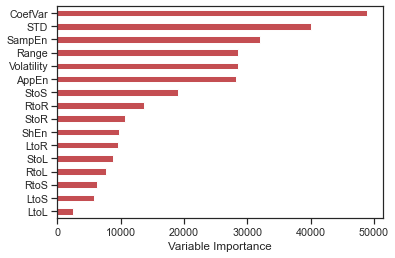

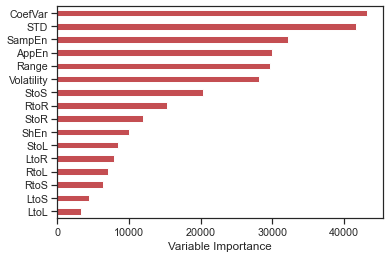

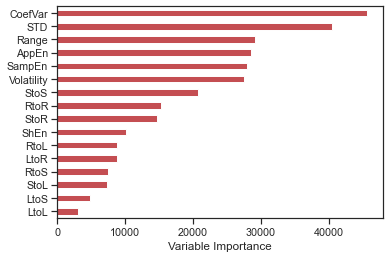

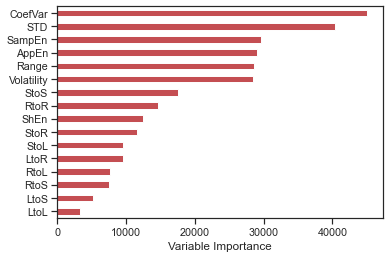

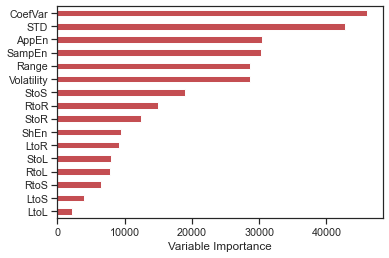

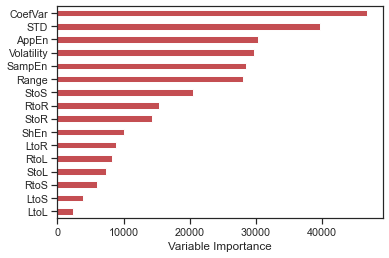

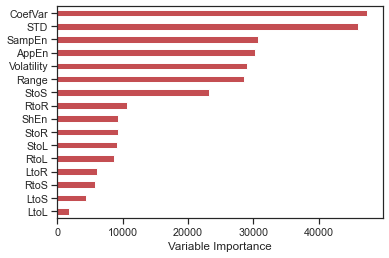

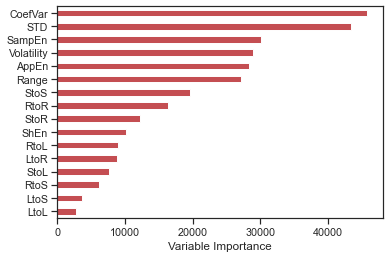

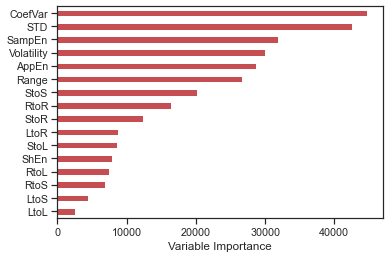

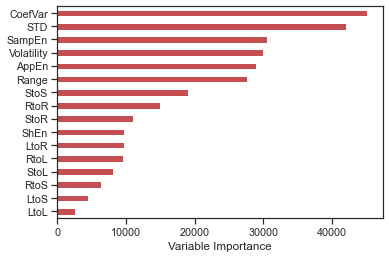

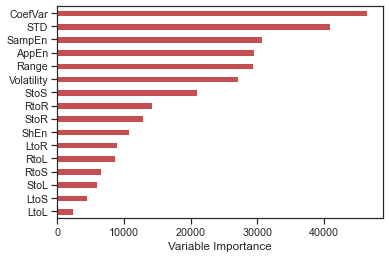

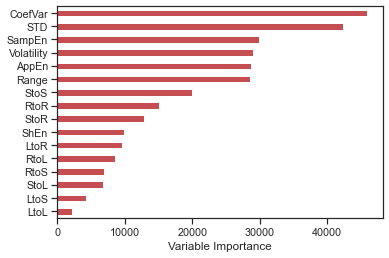

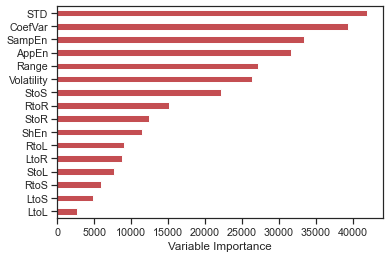

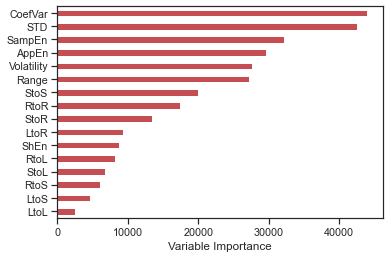

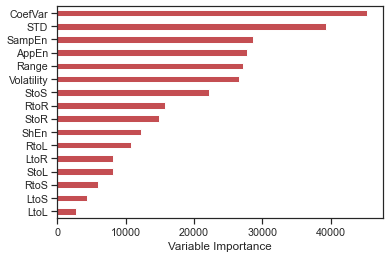

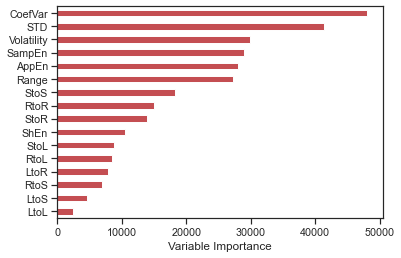

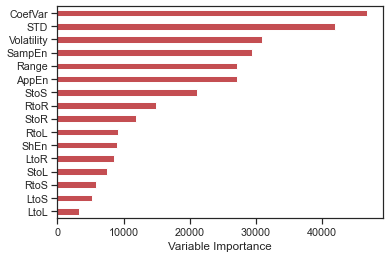

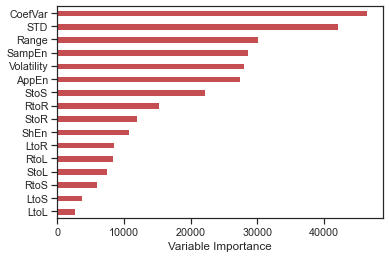

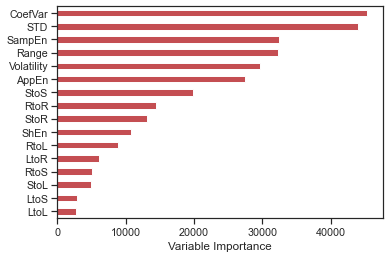

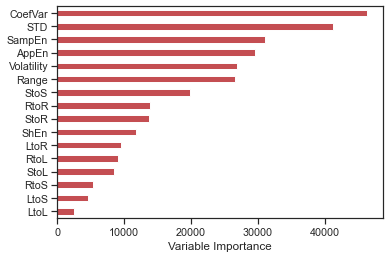

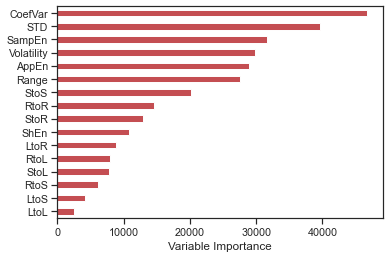

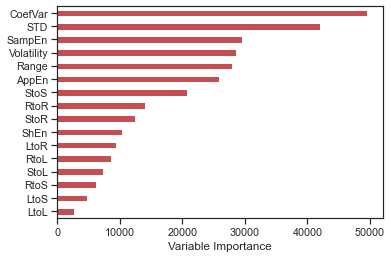

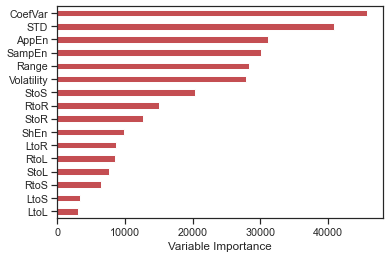

In [21]:
# https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
import lightgbm

#Implementing cross validation 
kf = KFold(n_splits=23, random_state=1, shuffle=True)
model = lightgbm.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42)

from time import time
import timeit #imports timeit module
start_time = timeit.default_timer() #defines start time so computational time can be calculated

acc_score = [];
Truth = [];
Output = [];
n_estimators_list = []
max_depth_list = []

x_values = ['StoS', 'StoR', 'StoL', 'RtoS', 'RtoR', 'RtoL', 'LtoS',
       'LtoR', 'LtoL', 'STD', 'CoefVar', 'Range', 'Volatility', 'ShEn',
       'AppEn', 'SampEn']
y_values = ['Rhythm']
df = features_maindf

for idx, subject in enumerate(good_list):
    
    train_index = ~df['Subject'].str.contains(subject)
    test_index = df['Subject'].str.contains(subject)
    X_train , X_test = df.loc[train_index,x_values], df.loc[test_index,x_values]
    y_train , y_test = df.loc[train_index,y_values].values.ravel(), df.loc[test_index,y_values]

    temp_model = model.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)],eval_metric='logloss')    
    param_distributions = {'n_estimators': randint(90, 110),
                           'max_depth': randint(3,10)}

    search = RandomizedSearchCV(estimator=temp_model, param_distributions=param_distributions, random_state=0)
    search.fit(X_train, y_train)

    n_estimators_list.append(search.best_params_['n_estimators'])
    max_depth_list.append(search.best_params_['max_depth'])

    model.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)],
          eval_metric='logloss')
    
    # Create the LightGBM data containers
    model.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)],
          eval_metric='logloss')

    pred_values = model.predict(X_test)
     
    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)
    
    Truth.extend(y_test.values.reshape(y_test.shape[0])); ## it is a list
    Output.extend(pred_values); ## it is a list  
    
    #print(model.feature_importances_)
    Importance = pd.DataFrame({'Importance':(model.feature_importances_*100)}, 
                          index = (X_train.columns))
    Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'r')
    plt.xlabel('Variable Importance')
    plt.gca().legend_ = None
    #plt.savefig('plot1.png')


elapsed = timeit.default_timer() - start_time #gives total computation time
print("---Run time is %s seconds ---" % elapsed) #prints computation time
print()

print('Accuracy of each fold: \n {}'.format(acc_score))
print()
print('Avg accuracy : \n{}'.format(np.mean(acc_score))); 
print()
print('Std of accuracy : \n{}'.format(np.std(acc_score)))

In [22]:
print(confusion_matrix(Truth, Output))
print(classification_report(Truth, Output))

[[23104  1639]
 [ 1720 18505]]
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     24743
           1       0.92      0.91      0.92     20225

    accuracy                           0.93     44968
   macro avg       0.92      0.92      0.92     44968
weighted avg       0.93      0.93      0.93     44968



In [16]:
print(param_distributions['n_estimators'])

In [18]:
print(search.best_params_['n_estimators'])

97
